In [1]:
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
%config InlineBackend.figure_format = "svg"

In [2]:
from configs import ConfigBase
config = ConfigBase()

In [3]:
import torch
from torch.utils.data import DataLoader

from IPython.display import clear_output

import argparse
from collections import defaultdict
from thop import profile

import matplotlib.pyplot as plt
plt.style.use("ggplot")

from configs import *

from kws.datasets import SpeechCommandDataset
from kws.augmentations import WaveAugs, LogMelSpec
from kws.collate_fn import Collator

from kws.sampler import *
from kws.models import *
from kws.trainer import *
from kws.utils import *

In [4]:
config = ConfigBase()

In [5]:
 # Load the data
dataset = SpeechCommandDataset(path_to_dir=config.path_to_data, keywords=config.keyword)

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * config.train_ratio)]
val_indexes = indexes[int(len(dataset) * config.train_ratio):]

df_train = dataset.csv.iloc[train_indexes].reset_index(drop=True)
df_val = dataset.csv.iloc[val_indexes].reset_index(drop=True)

train_set = SpeechCommandDataset(csv=df_train, transform=WaveAugs(config))
val_set = SpeechCommandDataset(csv=df_val)

train_sampler = get_sampler(train_set.csv["label"].values)
val_sampler = get_sampler(val_set.csv["label"].values)

train_loader = DataLoader(train_set, 
                          batch_size=config.batch_size,
                          shuffle=False,   # because of our sampler with randomness inside
                          collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=config.num_workers, 
                          pin_memory=True)

val_loader = DataLoader(val_set, 
                        batch_size=config.batch_size,
                        shuffle=False, 
                        collate_fn=Collator(),
                        sampler=val_sampler,
                        num_workers=config.num_workers, 
                        pin_memory=True)

In [6]:
melspec_train = LogMelSpec(is_train=True, config=config)
melspec_val = LogMelSpec(is_train=False, config=config)

if config.model_type == "base":
    model = CRNNBase(config).to(config.device)

In [7]:
history = defaultdict(list)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

In [8]:

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [9]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

In [10]:
from torch import nn

In [39]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [40]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [41]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.num_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [42]:
for batch in train_loader:
    break


In [43]:
batch

(tensor([[ 4.5776e-05,  8.3923e-05,  9.9182e-05,  ..., -9.9182e-05,
          -1.2207e-04, -1.1444e-04],
         [-1.3733e-03, -2.2888e-03, -1.0681e-03,  ..., -1.3123e-03,
           2.1362e-04, -7.3242e-04],
         [-1.5869e-03, -7.3853e-03, -1.3428e-03,  ..., -3.0823e-03,
          -2.5330e-03, -2.7466e-03],
         ...,
         [-6.8665e-05, -3.2043e-04, -6.2561e-04,  ..., -1.1444e-03,
          -8.4686e-04, -4.1199e-04],
         [ 3.2680e-03,  4.5232e-03,  8.4966e-03,  ...,  6.3010e-03,
           2.6905e-03,  2.1849e-03],
         [-3.7729e-03,  3.2092e-03, -1.9022e-02,  ...,  1.0829e-02,
           5.3158e-03,  1.0835e-02]]),
 tensor([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
         0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
         0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
         1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
         1, 0, 1, 1, 0, 1, 1, 

In [44]:
batch[0]

tensor([[ 4.5776e-05,  8.3923e-05,  9.9182e-05,  ..., -9.9182e-05,
         -1.2207e-04, -1.1444e-04],
        [-1.3733e-03, -2.2888e-03, -1.0681e-03,  ..., -1.3123e-03,
          2.1362e-04, -7.3242e-04],
        [-1.5869e-03, -7.3853e-03, -1.3428e-03,  ..., -3.0823e-03,
         -2.5330e-03, -2.7466e-03],
        ...,
        [-6.8665e-05, -3.2043e-04, -6.2561e-04,  ..., -1.1444e-03,
         -8.4686e-04, -4.1199e-04],
        [ 3.2680e-03,  4.5232e-03,  8.4966e-03,  ...,  6.3010e-03,
          2.6905e-03,  2.1849e-03],
        [-3.7729e-03,  3.2092e-03, -1.9022e-02,  ...,  1.0829e-02,
          5.3158e-03,  1.0835e-02]])

In [45]:
batch = melspec_train(batch[0])

In [311]:
batch.shape # (batch_size, num_mels, seq_len)

torch.Size([128, 40, 101])

In [47]:
x = batch[0]

In [310]:
x

tensor([[[ -7.4930,  -8.1689,  -7.7589,  ...,  -5.3716,  -5.8590,  -8.5366],
         [-11.3343, -10.0155,  -9.8519,  ...,  -9.2635,  -8.5032, -10.2463],
         [-11.4640,  -9.8133, -10.0044,  ..., -10.7341, -11.1499, -12.2946],
         ...,
         [-14.3313, -13.9099, -14.4119,  ..., -14.6615, -15.4683, -15.0765],
         [-15.1506, -14.9412, -15.0830,  ..., -15.9285, -16.3636, -15.6059],
         [-16.5907, -17.1821, -17.2173,  ..., -17.2536, -17.6222, -17.0664]]])

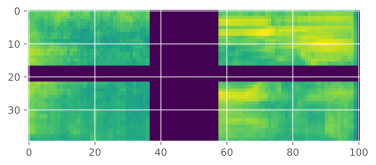

In [49]:
plt.imshow(batch[30])

In [465]:
model = StreamingCRNN(config = config, max_window_length = 41)

In [466]:
opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

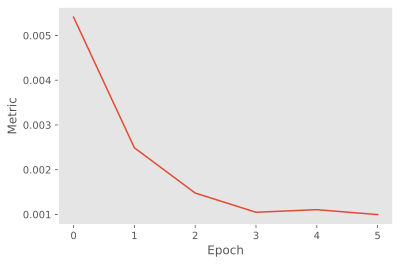

END OF EPOCH 5


  4%|▍         | 18/405 [00:06<02:21,  2.73it/s]


KeyboardInterrupt: 

In [468]:
for n in range(config.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [476]:
from pathlib import Path

In [484]:
audio_path =  Path().absolute().resolve() / "audio.wav"
audio, sr = torchaudio.load(audio_path)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: only one element tensors can be converted to Python scalars

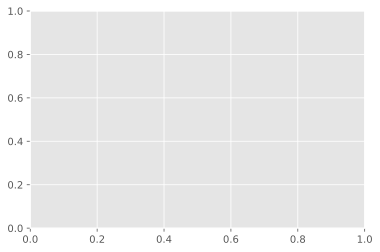

In [511]:
plot_audio_inference(audio, model)

In [513]:
history[0]

tensor([0.6694, 0.3306], grad_fn=<SelectBackward>)

In [514]:
def plot_audio_inference(audio, streaming_model, max_window_length=41, streaming_step_size=1):
    streaming_model.eval()

    melspec = LogMelSpec(is_train=False, config=config)
    spectrogram = melspec(audio)
    
    if len(spectrogram.shape) == 2:
        spectrogram.unsqueeze(0)

    hidden = None
    history = []

    streaming_model.set_buffer(spectrogram)

    for T in range(max_window_length, x.shape[2] + 1, streaming_step_size):
        window = spectrogram[:, :, T - max_window_length:T]  
        prob, hidden = streaming_model.inference(window, hidden)
        history.append(prob.cpu().detach()) 

    plt.plot(history)
    plt.xlabel("Frame")
    plt.ylabel("Probability of a keyword")

In [515]:
class StreamingCRNN(CRNN):
    
    def __init__(self, config):
        super().__init__(config)

    def inference(self, x, hidden=None):
        self.buffer = torch.cat((self.buffer, x), dim=2)[:, :, -self.config.max_window_length:]

        input = self.buffer.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, hidden = self.gru(conv_output, hidden)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)

        probs = F.softmax(output, dim=-1)

        return probs.detach().cpu(), hidden
    
    def set_buffer(self, x):
        self.buffer = torch.zeros(size=(1 if len(x.shape) == 2 else x.shape[0], 
                                        self.config.num_mels, 
                                        self.config.max_window_length), 
                                  device=self.config.device)

In [312]:
x.shape

torch.Size([1, 40, 101])

In [313]:
max_window_length = 40 + 1

In [448]:
streaming_step_size = 1

hidden = None
for T in range(max_window_length, x.shape[2] + 1, streaming_step_size):
    input = x[:, :, T - max_window_length:T]  

    if T == 42:
        print('hi')
        break
    #input_window = input_window.unsqueeze(dim=1)
#
    #conv_output_window = conv(input_window).transpose(-1, -2)
    #gru_output_window, hidden_window = gru(conv_output_window, hidden_window)
#
    #energy_window = attention(gru_output_window)

hi


In [430]:
input.shape

torch.Size([1, 40, 41])

In [431]:
buffer_input = torch.zeros(size=(1 if len(x.shape) == 2 else x.shape[0], 
                                              config.num_mels, 
                                              max_window_length), 
                                        device=config.device)

In [449]:
x

tensor([[[ -7.4930,  -8.1689,  -7.7589,  ...,  -5.3716,  -5.8590,  -8.5366],
         [-11.3343, -10.0155,  -9.8519,  ...,  -9.2635,  -8.5032, -10.2463],
         [-11.4640,  -9.8133, -10.0044,  ..., -10.7341, -11.1499, -12.2946],
         ...,
         [-14.3313, -13.9099, -14.4119,  ..., -14.6615, -15.4683, -15.0765],
         [-15.1506, -14.9412, -15.0830,  ..., -15.9285, -16.3636, -15.6059],
         [-16.5907, -17.1821, -17.2173,  ..., -17.2536, -17.6222, -17.0664]]])

In [450]:
buffer_input = torch.cat((buffer_input, input), dim=2)[:, :, -max_window_length:]

In [451]:
buffer_input

tensor([[[ -8.1689,  -7.7589,  -5.8838,  ..., -20.7233, -20.7233, -20.7233],
         [-10.0155,  -9.8519, -10.3687,  ..., -20.7233, -20.7233, -20.7233],
         [ -9.8133, -10.0044, -10.1616,  ..., -20.7233, -20.7233, -20.7233],
         ...,
         [-13.9099, -14.4119, -14.2037,  ..., -20.7233, -20.7233, -20.7233],
         [-14.9412, -15.0830, -14.7881,  ..., -20.7233, -20.7233, -20.7233],
         [-17.1821, -17.2173, -16.4650,  ..., -20.7233, -20.7233, -20.7233]]])

In [452]:
input = buffer_input.unsqueeze(dim=1)
conv_output = conv(input).transpose(-1, -2)
gru_output, hidden = gru(conv_output, hidden)

In [453]:
contex_vector = attention(gru_output)
output = classifier(contex_vector)

In [461]:
probs = torch.softmax(output, dim=1)

In [463]:
probs

tensor([[0.5271, 0.4729]], grad_fn=<SoftmaxBackward>)

In [462]:
torch.argmax(probs, dim=-1)

tensor([0])

In [436]:
buffer_contex_vector = torch.zeros(size=(1 if len(x.shape) == 2 else x.shape[0], 
                                              config.hidden_size), 
                                    device=config.device)

In [458]:
contex_vector

tensor([[ 0.1178, -0.0478,  0.2221,  0.4433, -0.2368,  0.4148, -0.0785, -0.1025,
         -0.0933,  0.0342,  0.2502, -0.1554,  0.2592, -0.1884, -0.1215, -0.0304,
         -0.0265,  0.1582, -0.0471,  0.3025, -0.1002,  0.0876,  0.2841, -0.3365,
         -0.3186, -0.1568,  0.2083,  0.0935, -0.2375,  0.0247,  0.0426, -0.3911,
          0.1842, -0.2574,  0.0961, -0.0289,  0.1591, -0.0260,  0.1557, -0.1448,
         -0.0329, -0.1313,  0.0360, -0.2665,  0.1548, -0.3185, -0.2189, -0.0507,
          0.3476,  0.2525,  0.5107,  0.1859, -0.5877, -0.3464, -0.2083, -0.0704,
          0.2127,  0.1627, -0.3997,  0.4088, -0.0872,  0.3846, -0.2203,  0.5807]],
       grad_fn=<SumBackward1>)

In [456]:
buffer_contex_vector = torch.cat((buffer_contex_vector, contex_vector), dim=1)[:, -config.hidden_size:]

In [457]:
buffer_contex_vector

tensor([[ 0.1178, -0.0478,  0.2221,  0.4433, -0.2368,  0.4148, -0.0785, -0.1025,
         -0.0933,  0.0342,  0.2502, -0.1554,  0.2592, -0.1884, -0.1215, -0.0304,
         -0.0265,  0.1582, -0.0471,  0.3025, -0.1002,  0.0876,  0.2841, -0.3365,
         -0.3186, -0.1568,  0.2083,  0.0935, -0.2375,  0.0247,  0.0426, -0.3911,
          0.1842, -0.2574,  0.0961, -0.0289,  0.1591, -0.0260,  0.1557, -0.1448,
         -0.0329, -0.1313,  0.0360, -0.2665,  0.1548, -0.3185, -0.2189, -0.0507,
          0.3476,  0.2525,  0.5107,  0.1859, -0.5877, -0.3464, -0.2083, -0.0704,
          0.2127,  0.1627, -0.3997,  0.4088, -0.0872,  0.3846, -0.2203,  0.5807]],
       grad_fn=<SliceBackward>)

In [447]:
buffer_contex_vector

tensor([[ 0.0899,  0.0135,  0.1876,  0.3413, -0.1670,  0.4417, -0.1478, -0.0200,
         -0.0687, -0.0083,  0.2980, -0.1820,  0.2628, -0.1607, -0.1097, -0.0313,
         -0.0312,  0.1067, -0.1314,  0.2961, -0.0945,  0.1460,  0.2117, -0.1921,
         -0.3038, -0.0092,  0.2024,  0.1235, -0.3558,  0.0210,  0.0398, -0.2946,
          0.1578, -0.3654,  0.1129, -0.0628,  0.0771,  0.0060,  0.2049, -0.0822,
         -0.1589, -0.1999, -0.0374, -0.1648,  0.0644, -0.3516, -0.2699, -0.0096,
          0.2750,  0.2839,  0.4898,  0.1235, -0.5708, -0.2538, -0.2432, -0.0086,
          0.2422,  0.2636, -0.3318,  0.2888, -0.1001,  0.4002, -0.2575,  0.5239]],
       grad_fn=<SliceBackward>)

In [426]:
contex_vector.shape

torch.Size([1, 64])

In [420]:
p = torch.softmax(output, dim=1)

In [421]:
p

tensor([[0.5675, 0.4325]], grad_fn=<SoftmaxBackward>)

In [412]:
energy.shape

torch.Size([1, 64])

In [ ]:
state_two_buffer = torch.zeros(size=(1 if len(x.shape) == 2 else x.shape[0], 
                                     max_window_length), 
                                     device=config.device)

In [404]:
state_two_buffer = torch.cat((self.energy_buffer, energy), dim=1)[:,-self.window_len:]

tensor([[[ 0.0967,  0.0230,  0.3324,  0.4713, -0.1905,  0.5401, -0.0885,
          -0.1907, -0.1284,  0.0716,  0.4379, -0.1406,  0.2414, -0.0766,
          -0.2299, -0.0442, -0.0796,  0.3014,  0.0116,  0.2856, -0.0940,
           0.0838,  0.4063, -0.3982, -0.3990, -0.1671,  0.2173,  0.2081,
          -0.3622,  0.0712,  0.0095, -0.5091,  0.2266, -0.2662,  0.2032,
          -0.1462,  0.1821, -0.0117,  0.1770, -0.2136, -0.1544, -0.2751,
          -0.0155, -0.4082,  0.3801, -0.5584, -0.2520, -0.0527,  0.4209,
           0.3848,  0.6161,  0.2181, -0.6958, -0.4833, -0.3560,  0.0151,
           0.2651,  0.3610, -0.4616,  0.4871, -0.0828,  0.4810, -0.3141,
           0.5886],
         [ 0.2218, -0.0092,  0.3870,  0.5330, -0.2754,  0.5784, -0.1543,
          -0.1233, -0.1184, -0.0041,  0.4963, -0.1762,  0.2442, -0.1020,
          -0.2701, -0.0184, -0.0600,  0.2888, -0.0182,  0.4132, -0.1403,
           0.0682,  0.3650, -0.3620, -0.4062, -0.1854,  0.3095,  0.1871,
          -0.4784,  0.0217,  0.

In [269]:
input_buffer.shape

torch.Size([1, 40, 41])

In [270]:
input_buffer = torch.cat((input_buffer, input_window), 2)

In [272]:
input_buffer

tensor([[[  0.0000,   0.0000,   0.0000,  ..., -20.7233, -20.7233, -20.7233],
         [  0.0000,   0.0000,   0.0000,  ..., -20.7233, -20.7233, -20.7233],
         [  0.0000,   0.0000,   0.0000,  ..., -20.7233, -20.7233, -20.7233],
         ...,
         [  0.0000,   0.0000,   0.0000,  ..., -20.7233, -20.7233, -20.7233],
         [  0.0000,   0.0000,   0.0000,  ..., -20.7233, -20.7233, -20.7233],
         [  0.0000,   0.0000,   0.0000,  ..., -20.7233, -20.7233, -20.7233]]])

In [238]:
input_buffer = input_buffer[:,:,-max_window_length:]

In [239]:
input = input_buffer.unsqueeze(dim=1)

In [240]:
input.shape

torch.Size([1, 1, 40, 41])

In [242]:
conv_output = conv(input).transpose(-1, -2)

In [244]:
conv_output.shape

torch.Size([1, 3, 144])

In [245]:
hidden = None
gru_output, hidden = gru(conv_output, hidden)

In [251]:
energy = attention(gru_output)

In [252]:
energy.shape

torch.Size([1, 64])

In [258]:
energy_buffer = torch.zeros((1, 41))

In [260]:
torch.cat((energy_buffer, energy), dim=1)

torch.Size([1, 105])

In [161]:
input_window = input_window.unsqueeze(dim=1)

In [162]:
input_window.shape

torch.Size([1, 1, 40, 41])

In [168]:
input_window.transpose(-1, -2).shape

torch.Size([1, 1, 41, 40])

In [169]:
conv_output_window = conv(input_window).transpose(-1, -2)

In [170]:
conv_output_window.shape

torch.Size([1, 3, 144])

In [177]:
energy_window = attention(gru_output_window)

In [188]:
energy_window.shape

torch.Size([1, 64])

In [149]:
conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

In [150]:
conv_out_frequency = (config.num_mels - config.kernel_size[0]) // config.stride[0] + 1

In [151]:
gru = nn.GRU(
            input_size=conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

In [152]:
conv_output = conv(input).transpose(-1, -2)

In [153]:
conv_output.shape

torch.Size([1, 3, 144])

In [154]:
gru_output, _ = gru(conv_output)

In [92]:
x[0]

tensor([[ -7.4930,  -8.1689,  -7.7589,  ...,  -5.3716,  -5.8590,  -8.5366],
        [-11.3343, -10.0155,  -9.8519,  ...,  -9.2635,  -8.5032, -10.2463],
        [-11.4640,  -9.8133, -10.0044,  ..., -10.7341, -11.1499, -12.2946],
        ...,
        [-14.3313, -13.9099, -14.4119,  ..., -14.6615, -15.4683, -15.0765],
        [-15.1506, -14.9412, -15.0830,  ..., -15.9285, -16.3636, -15.6059],
        [-16.5907, -17.1821, -17.2173,  ..., -17.2536, -17.6222, -17.0664]])

In [97]:
buffer_one[0]

tensor([[ -8.1689,  -7.7589,  -5.8838,  ..., -20.7233, -20.7233, -20.7233],
        [-10.0155,  -9.8519, -10.3687,  ..., -20.7233, -20.7233, -20.7233],
        [ -9.8133, -10.0044, -10.1616,  ..., -20.7233, -20.7233, -20.7233],
        ...,
        [-13.9099, -14.4119, -14.2037,  ..., -20.7233, -20.7233, -20.7233],
        [-14.9412, -15.0830, -14.7881,  ..., -20.7233, -20.7233, -20.7233],
        [-17.1821, -17.2173, -16.4650,  ..., -20.7233, -20.7233, -20.7233]])

In [57]:
buffer_one

NameError: name 'buffer_one' is not defined

In [ ]:
buffer_one

In [174]:
conv = nn.Sequential(
    nn.Conv2d(
        in_channels=1, out_channels=config.cnn_out_channels,
        kernel_size=config.kernel_size, stride=config.stride
    ),
    nn.Flatten(start_dim=1, end_dim=2),
    )

conv_out_frequency = (config.num_mels - config.kernel_size[0]) // \
config.stride[0] + 1

gru = nn.GRU(
    input_size=conv_out_frequency * config.cnn_out_channels,
    hidden_size=config.hidden_size,
    num_layers=config.gru_num_layers,
    dropout=0.1,
    bidirectional=config.bidirectional,
    batch_first=True
    )

attention = Attention(config.hidden_size)
classifier = nn.Linear(config.hidden_size, config.num_classes)

energy = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh(),
            nn.Linear(config.hidden_size, 1)
        )
    